In [1]:
import time
import os
import subprocess
import sys
import re
import argparse
import collections
import gzip
import math
import shutil



import matplotlib.pyplot as plt
import wandb
import numpy as np
import time
from datetime import datetime
import random

import seaborn as sns
%matplotlib inline
import logging
from silence_tensorflow import silence_tensorflow
#silence_tensorflow()
#os.environ['TPU_LOAD_LIBRARY']='0'
os.environ['TF_ENABLE_EAGER_CLIENT_STREAMING_ENQUEUE']='False'
import tensorflow as tf


import tensorflow.experimental.numpy as tnp
import tensorflow_addons as tfa
from tensorflow import strings as tfs
from tensorflow.keras import mixed_precision
from scipy.stats.stats import pearsonr  
from scipy.stats.stats import spearmanr  
## custom modules
import metrics as metrics
from optimizers import *
import schedulers as schedulers

import training_utils_enformer_performer as training_utils

import enformer_performer as enformer_performer

from scipy import stats


2023-01-18 02:51:28.196947: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-18 02:51:28.372947: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-18 02:51:28.372993: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-18 02:51:29.318048: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

ValueError: Custom>sinusoidal has already been registered to <function sinusoidal at 0x7f0faf14bf80>

In [2]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='node-5')
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

with strategy.scope():
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy=\
        tf.data.experimental.AutoShardPolicy.FILE
    options.deterministic=False
    options.experimental_threading.max_intra_op_parallelism=1
    mixed_precision.set_global_policy('mixed_bfloat16')
    #options.num_devices = 64

    BATCH_SIZE_PER_REPLICA = 1 # batch size 24, use LR ~ 2.5 e -04
    NUM_REPLICAS = strategy.num_replicas_in_sync
    GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * NUM_REPLICAS
    

2022-12-28 02:08:13.498255: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-28 02:08:13.498309: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-28 02:08:13.498332: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tpu-genformer-v2-6): /proc/driver/nvidia/version does not exist


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


2022-12-28 02:08:13.783057: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
2022-12-28 02:08:13.820446: I tensorflow/core/distributed_runtime/rpc/grpc_server_lib.cc:447] Started server with target: grpc://localhost:49556


INFO:tensorflow:Initializing the TPU system: node-5


INFO:tensorflow:Initializing the TPU system: node-5


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [3]:
iterators={'human': ('gs://genformer_data/expanded_originals/196k',5313),
           'mouse': ('gs://genformer_data/expanded_originals/196k',1643)}
           
g = tf.random.Generator.from_non_deterministic_state()
tr_data_it_dict,val_data_it_dict,val_data_TSS_it =  \
    training_utils.return_distributed_iterators(iterators,
                                                "gs://genformer_data/expanded_originals/196k/human/tfrecords_tss",
                                                 GLOBAL_BATCH_SIZE,
                                                 196608,
                                                 10,
                                                 4,
                                                 10,
                                                 strategy,
                                                 options,
                                                g)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [4]:
with strategy.scope():
    model = enformer_performer.enformer_performer(
        num_transformer_layers=11,
        num_heads=8,
        heads_channels= {'human': 5313,
                         'mouse': 1643},
        stable_variant=True,
        dim=192,
        d_model=1536,
        norm=True,
        max_seq_length=1536,
        nb_random_features=256,
        hidden_size=1536,
        numerical_stabilizer=0.001,
        rel_pos_bins=1536,
        use_mask_pos=False,
        use_rot_emb=True,
        kernel_transformation="softmax_kernel_transformation",
        normalize=True,
        seed=5)

In [5]:
with strategy.scope():        

    optimizer1 = tf.keras.optimizers.Adam(learning_rate=1.0e-04)

    optimizer2 = tf.keras.optimizers.Adam(learning_rate=1.0e-04)
    optimizers_in = optimizer1,optimizer2

    metric_dict = {}
    organism_dict = {'human': (500,30),
                     'mouse': (500,30)}

    dist_train_step, dist_val_step_h,dist_val_step_m, val_step_TSS, build_step,metric_dict = training_utils.return_train_val_functions(model,
                                                                                                                                         50,
                                                                                                                                       50,
                                                                                                                                       50,
                                                                                                                                         50,
                                                                                                                                         optimizers_in,
                                                                                                                                         strategy,
                                                                                                                                         metric_dict, 
                                                                                                                                         GLOBAL_BATCH_SIZE,
                                                                                                                                        0.20,
                                                                                                                                         BATCH_SIZE_PER_REPLICA,
                                                                                                                                        loss_fn_main='poisson')


In [7]:
with strategy.scope():        
    ### main training loop
    global_step = 0
    val_losses = []
    val_pearsons = []
    val_R2 = []
    patience_counter = 0
    stop_criteria = False
    best_epoch = 0

    for epoch_i in range(1, 4):
        print('starting epoch_', str(epoch_i))
        start = time.time()
        if epoch_i == 1:
            # run once to build the model w/o updating anything
            build_step(val_data_it_dict['human'])

        dist_train_step(tr_data_it_dict['human'],
                        tr_data_it_dict['mouse'])
        


        end = time.time()
        duration = (end - start) / 60.
        print('completed epoch ' + str(epoch_i))
        print('hg_train_loss: ' + str(metric_dict['human_tr'].result().numpy()))
        
        print('training duration(mins): ' + str(duration))

        start = time.time()
        dist_val_step_h(val_data_it_dict['human'])

        print('val_loss: ' + str(metric_dict['human_val'].result().numpy()))
        val_losses.append(metric_dict['human_val'].result().numpy())

        print('human_pearsonsR: ')
        pearsonsR=metric_dict['human_pearsonsR'].result()['PearsonR'].numpy()
        print(pearsonsR)

        val_pearsons.append(np.nanmedian(pearsonsR))
        print('human_R2: ')
        print(metric_dict['human_R2'].result()['R2'].numpy())


        end = time.time()
        duration = (end - start) / 60.
        print('completed epoch ' + str(epoch_i) + ' validation')
        print('validation duration(mins): ' + str(duration))
        print('patience counter at: ' + str(patience_counter))

        
        val_step_TSS(val_data_TSS_it)
        

        y_trues = metric_dict['hg_corr_stats'].result()['y_trues'].numpy()
        y_preds = metric_dict['hg_corr_stats'].result()['y_preds'].numpy()
        cell_types = metric_dict['hg_corr_stats'].result()['cell_types'].numpy()
        gene_map = metric_dict['hg_corr_stats'].result()['gene_map'].numpy()
        
        
        
        if (epoch_i > 2):
            stop_criteria,patience_counter,best_epoch = \
                training_utils.early_stopping(current_val_loss=val_losses[-1],
                                                logged_val_losses=val_losses,
                                                current_pearsons=val_pearsons[-1],
                                                logged_pearsons=val_pearsons,
                                                current_epoch=epoch_i,
                                                best_epoch=best_epoch,
                                                save_freq=5,
                                                patience=5,
                                                patience_counter=patience_counter,
                                                min_delta=1.0e-05,
                                                model=enformer_model,
                                                save_directory="gs://picard-testing-176520/test",
                                                saved_model_basename="test_model",
                                                checkpoint=checkpoint)
        #plt.close('all')
        print('patience counter at: ' + str(patience_counter))
        for key, item in metric_dict.items():
            item.reset_state()

starting epoch_ 1


completed epoch 1
hg_train_loss: 0.10304573
training duration(mins): 6.337669161955516
val_loss: 0.10204952
human_pearsonsR: 
[-0.01178927 -0.01963302 -0.02671412 ... -0.0026256  -0.00525206
 -0.00349261]
human_R2: 
[-1.43055916e-02 -1.15620375e-01 -8.67861509e-02 ... -9.97424126e-04
 -1.09314919e-03 -8.85725021e-05]
completed epoch 1 validation
validation duration(mins): 1.615167506535848
patience counter at: 0


TypeError: in user code:

    File "/home/jupyter/dev/genformer_public/enformer_batch_norm_experiments/training_utils_enformer_performer.py", line 407, in val_step  *
        target=tf.cast(inputs['target'],

    TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got 'target'


In [ ]:
gamma_names=[]
gamma_vars=[]

beta_names=[]
beta_vars=[]

moving_means_names=[]
moving_means_vars=[]

moving_vars_names=[]
moving_vars_vars=[]

all_vars=[(k,x.name,x) for k,x in enumerate(model.stem_res_conv.variables)]

for gamma_tuple in all_vars:
    if 'sync_batch_normalization' in gamma_tuple[1]:
        
        specific_var = gamma_tuple[1].split('/')[1].split(':')[0]

        var_name = specific_var + "_1"
        vals = list(np.log(1.0+gamma_tuple[-1].values[0].numpy()))
        #print(vals)
        names = []
        for variable_val in vals:
            names.append(var_name)
        if 'gamma' in var_name:
            gamma_names += names
            gamma_vars += vals
        if 'beta' in var_name:
            beta_names += names
            beta_vars += vals
        if 'moving_mean' in var_name:
            moving_means_names += names
            moving_means_vars += vals
        if 'moving_variance' in var_name:
            moving_vars_names += names
            moving_vars_vars += vals    
        
            
all_vars=[(k,x.name,x) for k,x in enumerate(model.conv_tower.variables)]

for gamma_tuple in all_vars:
    if 'sync_batch_normalization' in gamma_tuple[1]:
        specific_var = gamma_tuple[1].split('/')[1].split(':')[0]
        layer_num= int(gamma_tuple[1].split('/')[0].split('_')[-1])+1
        
        var_name = specific_var + "_" + str(layer_num)
        vals = list(np.log(1.0+gamma_tuple[-1].values[0].numpy()))
        #print(vals)
        names = []
        for variable_val in vals:
            names.append(var_name)
        if 'gamma' in var_name:
            gamma_names += names
            gamma_vars += vals
        if 'beta' in var_name:
            beta_names += names
            beta_vars += vals
        if 'moving_mean' in var_name:
            moving_means_names += names
            moving_means_vars += vals
        if 'moving_variance' in var_name:
            moving_vars_names += names
            moving_vars_vars += vals    
        

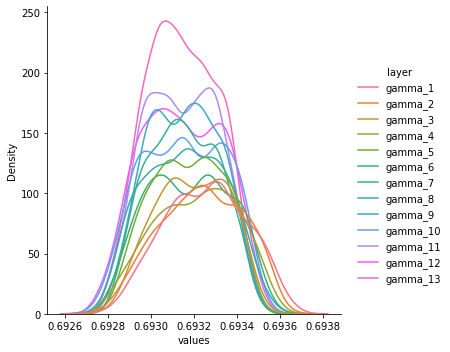

In [8]:
import pandas as pd
import seaborn as sns
gamma_df=pd.DataFrame(list(zip(gamma_names, gamma_vars)), columns =['layer', 'values'])
sns.displot(data=gamma_df, x="values", hue="layer", kind="kde")

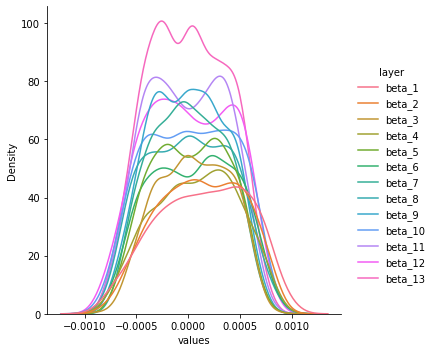

In [9]:
beta_df=pd.DataFrame(list(zip(beta_names, beta_vars)), columns =['layer', 'values'])
sns.displot(data=beta_df, x="values", hue="layer", kind="kde")

In [85]:
np.log(2)

0.6931471805599453

In [12]:
out=exponential_linspace_int(start=768, end=1536,num=6, divisible_by=128)

In [10]:
    results_df = pd.DataFrame()
    results_df['true'] = y_trues
    results_df['pred'] = y_preds
    results_df['gene_encoding'] =gene_map
    results_df['cell_type_encoding'] = cell_types

None


In [19]:
import pandas as pd
results_df = pd.DataFrame()
results_df['test']=np.random.normal(0, 1, 20)
results_df['test1']=np.random.normal(0, 1, 20)
results_df['group1']=np.array([1,2] * 10)
results_df['group2']=np.array(['A','B'] * 10)

In [20]:
results_df.groupby('group1')[['test','test1']].corr(method='pearson').unstack().iloc[:,1].tolist()

[-0.05797280165825752, -0.249068029203528]

In [28]:
from scipy.stats.stats import pearsonr, spearmanr
indices = [x for x in range(0,20,2)]

In [29]:
pearsonr(results_df[['test']].to_numpy()[:,0][indices],
         results_df[['test1']].to_numpy()[:,0][indices])
         

(-0.05797280165825758, 0.8736098449541455)

In [27]:
results_df[['test']].to_numpy().shape

(20, 1)

In [38]:
test1=tf.constant([[[0.,1.,2.],
                   [0.,0.,0.]]])

test2=tf.constant([[[0.,0.,0.],
                   [0.,1.,2.]]])

In [43]:
tf.reduce_mean(tf.keras.losses.poisson(tf.transpose(test1, perm=[0, 2, 1]),tf.transpose(test2, perm=[0, 2, 1])))

<tf.Tensor: shape=(), dtype=float32, numpy=8.559048>

In [44]:
tf.keras.losses.poisson(tf.transpose(test1, perm=[0, 2, 1]),tf.transpose(test2, perm=[0, 2, 1]))

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 0.      ,  8.559048, 17.118095]], dtype=float32)>

In [45]:
(17.118095 + 8.559048) / 3

8.559047666666666

In [48]:
t=tf.keras.losses.Poisson(reduction=tf.keras.losses.Reduction.NONE)

t(tf.transpose(test1, perm=[0, 2, 1]),tf.transpose(test2, perm=[0, 2, 1]))

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 0.      ,  8.559048, 17.118095]], dtype=float32)>

In [17]:
def deserialize(serialized_example):
    """Deserialize bytes stored in TFRecordFile."""
    feature_map = {
      'sequence': tf.io.FixedLenFeature([], tf.string),
      'target': tf.io.FixedLenFeature([], tf.string),
    }
    
    data = tf.io.parse_example(serialized_example, feature_map)

    sequence = tf.io.decode_raw(data['sequence'], tf.bool)
    sequence = tf.reshape(sequence, (131072, 4))
    sequence = tf.cast(sequence, tf.float32)
    
    target = tf.io.decode_raw(data['target'], tf.float16)
    target = tf.reshape(target,
                        (896, 5313))

    return {'sequence': tf.ensure_shape(sequence,
                                        [131072,4]),
            'target': tf.ensure_shape(target,
                                      [896,5313])}


dataset = tf.data.TFRecordDataset("gs://terra_cagerna/basenji_barnyard/data/human/tfrecords/train-0-0.tfr",
                                  compression_type='ZLIB',
                                  num_parallel_reads=4)

dataset=dataset.map(lambda record: deserialize(record),
                                               num_parallel_calls=4)
dataset_iter=iter(dataset.batch(1))

In [18]:
out=next(dataset_iter)

In [30]:
def deserialize_val_TSS(serialized_example,input_length=196608,max_shift=10, out_length=896,num_targets=5313):
    """Deserialize bytes stored in TFRecordFile."""
    feature_map = {
        'sequence': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.string),
        'tss_mask': tf.io.FixedLenFeature([], tf.string),
        'gene_name': tf.io.FixedLenFeature([], tf.string)
    }
    
    data = tf.io.parse_example(serialized_example, feature_map)

    shift = 5
    input_seq_length = input_length + max_shift
    interval_end = input_length + shift
    
    ### rev_comp
    #rev_comp = random.randrange(0,2)

    example = tf.io.parse_example(serialized_example, feature_map)
    sequence = tf.io.decode_raw(example['sequence'], tf.bool)
    sequence = tf.reshape(sequence, (input_length + max_shift, 4))
    sequence = tf.cast(sequence, tf.float32)
    sequence = tf.slice(sequence, [shift,0],[input_length,-1])
    
    target = tf.io.decode_raw(example['target'], tf.float16)
    target = tf.reshape(target,
                        (out_length, num_targets))
    
    tss_mask = tf.io.parse_tensor(data['tss_mask'],
                                  out_type=tf.int32)

    
    gene_name= tf.io.parse_tensor(example['gene_name'],out_type=tf.int32)
    gene_name = tf.tile(tf.expand_dims(gene_name,axis=0),[638])
    cell_types = tf.range(0,638)
    
    return {'sequence': tf.ensure_shape(sequence,
                                        [input_length,4]),
            'target': tf.ensure_shape(target,
                                      [896,num_targets]),
            'tss_mask': tf.ensure_shape(tss_mask,
                                        [896,1]),
            'gene_name': tf.ensure_shape(gene_name,
                                         [638,]),
            'cell_types': tf.ensure_shape(cell_types,
                                           [638,])}

In [31]:
dataset = tf.data.TFRecordDataset("gs://genformer_data/expanded_originals/196k/human/tfrecords_tss/tssmask-valid-0-0.tfr",
                                  compression_type='ZLIB',
                                  num_parallel_reads=4)
#dataset = dataset.with_options(options)
dataset = dataset.map(lambda record: deserialize_val_TSS(record),
                      deterministic=False,
                      num_parallel_calls=4)
dataset=iter(dataset)

In [33]:
test=next(dataset)
np.nonzero(test['tss_mask'].numpy())

(array([281, 282, 283, 284]), array([0, 0, 0, 0]))

PerReplica:{
  0: <tf.Tensor: shape=(1, 896, 5313), dtype=float16, numpy=
array([[[0.01155 , 0.02716 , 0.0206  , ..., 0.      , 0.      ,
         0.      ],
        [0.0109  , 0.04666 , 0.0309  , ..., 0.      , 0.      ,
         0.      ],
        [0.00792 , 0.035   , 0.01932 , ..., 0.      , 0.      ,
         0.      ],
        ...,
        [0.      , 0.006863, 0.      , ..., 0.      , 0.      ,
         0.      ],
        [0.      , 0.      , 0.002575, ..., 0.      , 0.0795  ,
         0.      ],
        [0.014786, 0.      , 0.03992 , ..., 0.      , 0.1423  ,
         0.      ]]], dtype=float16)>,
  1: <tf.Tensor: shape=(1, 896, 5313), dtype=float16, numpy=
array([[[0.09924 , 0.0927  , 0.01834 , ..., 0.      , 0.      ,
         0.      ],
        [0.11127 , 0.1686  , 0.03397 , ..., 0.      , 0.9844  ,
         0.      ],
        [0.1432  , 0.2322  , 0.01851 , ..., 0.      , 0.      ,
         0.      ],
        ...,
        [0.00663 , 0.01672 , 0.007565, ..., 0.01852 , 0.11566 ,


In [2]:
def exponential_linspace_int(start, end, num, divisible_by=1):
  """Exponentially increasing values of integers."""
  def _round(x):
    return int(np.round(x / divisible_by) * divisible_by)

  base = np.exp(np.log(end / start) / (num - 1))
  return [_round(start * base**i) for i in range(num)]

In [3]:
print(exponential_linspace_int(192,384,6))

[192, 221, 253, 291, 334, 384]
